In [2]:
from azure.identity import DefaultAzureCredential, ClientSecretCredential
from azure.storage.blob import BlobServiceClient
from azure.storage.filedatalake import DataLakeServiceClient

import os
import librosa
import io
import pyspark
import numpy as np
import matplotlib.pyplot as plt
import pyarrow as pa
from pyarrow import parquet as pq, csv
import pyarrow.fs as pa_fs
import pyarrowfs_adlgen2 as pa_adl
import librosa
import duckdb


from dotenv import load_dotenv
from pathlib import Path

%load_ext autoreload
%autoreload 2

In [2]:
# this is strictly used only in development
# load env variables
env_dir = Path('../').resolve()
load_dotenv(os.path.join(env_dir, '.env'))

True

In [3]:
# Retrieve credentials from environment variables
storage_account_name = os.environ.get("STORAGE_ACCOUNT_NAME")
storage_account_key = os.environ.get("STORAGE_ACCOUNT_KEY")

In [4]:
hertz = 16000

In [5]:
SUBJECT_NAME = "1028-20100710-hne"

In [6]:
DIR = f"../include/data/bronze/{SUBJECT_NAME}/"

In [7]:
WAV_DIR = os.path.join(DIR, "wav")

In [8]:
path_to_wavs = os.listdir(WAV_DIR)
path_to_wavs

['ar-01.wav',
 'ar-02.wav',
 'ar-03.wav',
 'ar-04.wav',
 'ar-05.wav',
 'ar-06.wav',
 'ar-07.wav',
 'rp-29.wav',
 'rp-30.wav',
 'rp-31.wav']

In [9]:
ys = []
for wav in path_to_wavs:
    y, sr = librosa.load(os.path.join(WAV_DIR, wav), sr=hertz)
    
    # top_db is set to 20 representing any signal below
    # 20 decibels will be considered silence
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)

#     # append y to ys 
    ys.append(y_trimmed)

In [10]:
final = np.concatenate(ys, axis=0)
final

array([-0.01312256, -0.01303101, -0.01281738, ...,  0.00253296,
        0.00219727,  0.00201416], shape=(521216,), dtype=float32)

In [11]:
table = pa.table({
    "signals": pa.array(final), 
    "subjectId": pa.array(["1028-20100710-hne"] * final.shape[0], type=pa.string()),
    "rowId": pa.array(np.arange(final.shape[0]), type=pa.int32())
})

In [12]:
table

pyarrow.Table
signals: float
subjectId: string
rowId: int32
----
signals: [[-0.013122559,-0.013031006,-0.012817383,-0.012481689,-0.0121154785,...,0.0018005371,0.0021362305,0.002532959,0.0021972656,0.0020141602]]
subjectId: [["1028-20100710-hne","1028-20100710-hne","1028-20100710-hne","1028-20100710-hne","1028-20100710-hne",...,"1028-20100710-hne","1028-20100710-hne","1028-20100710-hne","1028-20100710-hne","1028-20100710-hne"]]
rowId: [[0,1,2,3,4,...,521211,521212,521213,521214,521215]]

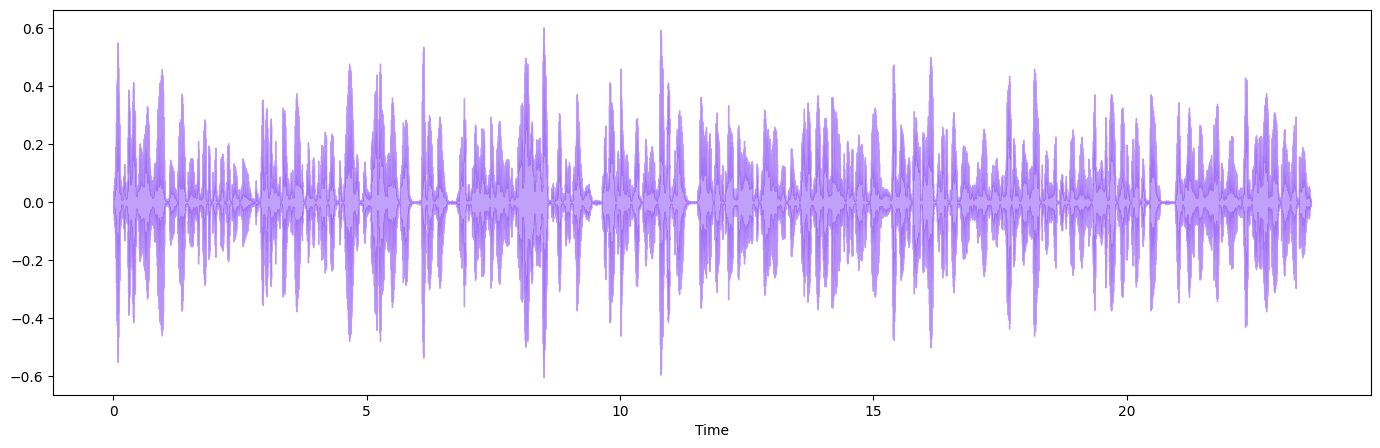

In [13]:
fig = plt.figure(figsize=(17, 5))
librosa.display.waveshow(final, alpha=0.5, color="#8442f5")
plt.show()

In [44]:
# SILVER_DATA_PATH = f"../include/data/silver/stage-01/train/{SUBJECT_NAME}_signals.parquet"
SILVER_DATA_PATH = f"../include/data/silver/stage-01/train/{SUBJECT_NAME}_signals.csv"
# SILVER_FOLDER_NAME = f"{storage_account_name}-silver"
# SUB_FOLDER_NAME = "stage-01"
# FILE_NAME = f"{SUBJECT_NAME}_signals.parquet"
# SILVER_DATA_PATH = os.path.join(SILVER_FOLDER_NAME, SUB_FOLDER_NAME, FILE_NAME)\
# .replace("\\", "/")
SILVER_DATA_PATH

'../include/data/silver/stage-01/train/1snoke-20120412-hge_signals.csv'

# local way of saving the py arrow table to parquet

In [37]:
# pq.write_table(table, SILVER_DATA_PATH)

# cloud way of saving the py arrow table to parquet

In [38]:
# create client with generated sas token
datalake_service_client = DataLakeServiceClient(
    account_url=f"https://{storage_account_name}.dfs.core.windows.net", 
    credential=storage_account_key
)

In [39]:
handler = pa_adl.AccountHandler.from_account_name(storage_account_name, credential=storage_account_key)

In [40]:
fs = pa.fs.PyFileSystem(handler)

# write time takes approximately 1 min assuming length of signals is 600000+

In [45]:
df = csv.write_csv(table, SILVER_DATA_PATH)
# df = pq.write_table(table, SILVER_DATA_PATH)
# df = pq.write_table(table, SILVER_DATA_PATH, filesystem=fs)

# For imputation based on a columns subject ids. The idea is we want to get the average of a particular partition of a column in the table and use this average to only impute this partitions missing/null values

In [12]:
# 1. Create a sample PyArrow Table with NULL values
features_data = pa.Table.from_arrays([
    pa.array([1, 1, 1, 3, 3, 3]),
    pa.array([None, 5, None, 1, None, 2]),
    pa.array([None, 2, 20, 4, None, 4]),
    pa.array([0.145, 3, 0.34, None, None, 1])
], names=['subject_id', 'feature_1', 'feature_2', 'feature_3'])

print("Original Table with Nulls:")
print(features_data.to_pandas())
print("-" * 40)

# 2. Connect to DuckDB and register the table
conn = duckdb.connect()

Original Table with Nulls:
   subject_id  feature_1  feature_2  feature_3
0           1        NaN        NaN      0.145
1           1        5.0        2.0      3.000
2           1        NaN       20.0      0.340
3           3        1.0        4.0        NaN
4           3        NaN        NaN        NaN
5           3        2.0        4.0      1.000
----------------------------------------


In [17]:
# 3. Execute the SQL query to perform the imputation
# We use a WITH clause (CTE) to make the code more readable
conn.sql("""
    SELECT
        *,
        AVG(feature_1) OVER(PARTITION BY subject_id) AS feature_1_avg,
        AVG(feature_2) OVER(PARTITION BY subject_id) AS feature_2_avg,
        AVG(feature_3) OVER(PARTITION BY subject_id) AS feature_3_avg
    FROM features_data
""")

┌────────────┬───────────┬───────────┬───────────┬───────────────┬───────────────┬────────────────────┐
│ subject_id │ feature_1 │ feature_2 │ feature_3 │ feature_1_avg │ feature_2_avg │   feature_3_avg    │
│   int64    │   int64   │   int64   │  double   │    double     │    double     │       double       │
├────────────┼───────────┼───────────┼───────────┼───────────────┼───────────────┼────────────────────┤
│          3 │         1 │         4 │      NULL │           1.5 │           4.0 │                1.0 │
│          3 │      NULL │      NULL │      NULL │           1.5 │           4.0 │                1.0 │
│          3 │         2 │         4 │       1.0 │           1.5 │           4.0 │                1.0 │
│          1 │      NULL │      NULL │     0.145 │           5.0 │          11.0 │ 1.1616666666666666 │
│          1 │         5 │         2 │       3.0 │           5.0 │          11.0 │ 1.1616666666666666 │
│          1 │      NULL │        20 │      0.34 │           5.0

# how this works is where ever null values are in a column coalesce essentially takes in the value corresponding to its row and uses that to fill in the null value and if it already has a value then that value is retained e.g.
```
1 -> 1.0 = 1.0
null -> 1.0 = 1.0
2 -> 1.0 = 2.0
null -> 1.16 = 1.16
5 -> 1.16 = 5.0
null -> 1.16 = 1.6
```
so essentially we can use a column in coalesce other than a single literal value so long as this column is exactly the same length as the column being imputed 

In [34]:
# 3. Execute the SQL query to perform the imputation
# We use a WITH clause (CTE) to make the code more readable
conn.sql("""
    SELECT
        *,
        COALESCE(feature_1, AVG(feature_1) OVER(PARTITION BY subject_id)) AS feature_1_imp,
        COALESCE(feature_2, AVG(feature_2) OVER(PARTITION BY subject_id)) AS feature_2_imp,
        COALESCE(feature_3, AVG(feature_3) OVER(PARTITION BY subject_id)) AS feature_3_imp
    FROM features_data
""")

┌────────────┬───────────┬───────────┬───────────┬───────────────┬───────────────┬───────────────┐
│ subject_id │ feature_1 │ feature_2 │ feature_3 │ feature_1_imp │ feature_2_imp │ feature_3_imp │
│   int64    │   int64   │   int64   │  double   │    double     │    double     │    double     │
├────────────┼───────────┼───────────┼───────────┼───────────────┼───────────────┼───────────────┤
│          1 │      NULL │      NULL │     0.145 │           5.0 │          11.0 │         0.145 │
│          1 │         5 │         2 │       3.0 │           5.0 │           2.0 │           3.0 │
│          1 │      NULL │        20 │      0.34 │           5.0 │          20.0 │          0.34 │
│          3 │         1 │         4 │      NULL │           1.0 │           4.0 │           1.0 │
│          3 │      NULL │      NULL │      NULL │           1.5 │           4.0 │           1.0 │
│          3 │         2 │         4 │       1.0 │           2.0 │           4.0 │           1.0 │
└─────────